I'm looking into doing a delta_sigma emulator. This is testing if the cat side works. Then i'll make an emulator for it. 

In [1]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [4]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [5]:
print z

0.232741617357


In [6]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a, particles=True, tol = 0.01, downsample_factor=1e-2)

In [7]:
cat.load_model(a, 'redMagic')

In [8]:
params = cat.model.param_dict.copy()
#params['mean_occupation_centrals_assembias_param1'] = 0.0
#params['mean_occupation_satellites_assembias_param1'] = 0.0
params['logMmin'] = 13.4
params['sigma_logM'] = 0.1
params['f_c'] = 1.0
params['alpha'] = 1.0
params['logM1'] = 14.0
params['logM0'] = 12.0

print params

{'logM1': 14.0, 'logMmin': 13.4, 'f_c': 1.0, 'logM0': 12.0, 'sigma_logM': 0.1, 'alpha': 1.0}


In [9]:
cat.populate(params)

In [10]:
nd_cat =  cat.calc_analytic_nd()
print nd_cat

7.06666614097e-05


In [47]:
rp_bins = np.logspace(-1.1, 1.5, 9) #binning used in buzzard mocks
rpoints = (rp_bins[1:]+rp_bins[:-1])/2

In [48]:
rpoints

array([  0.12365661,   0.2613469 ,   0.5523538 ,   1.1673937 ,
         2.46727379,   5.21455612,  11.0209072 ,  23.29256658])

In [12]:
ds = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/ds.npy')

[]

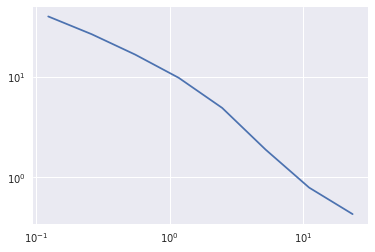

In [13]:
plt.plot(rpoints, ds)
plt.loglog();
#plt.xscale('log')

In [14]:
from astropy import constants as c

In [15]:
rpoints.shape

(8,)

Use my code's wrapper for halotools' xi calculator. Full source code can be found [here](https://github.com/mclaughlin6464/pearce/blob/31e2f6a3598217dcf1be3d2606b69c4e529fc791/pearce/mocks/cat.py#L688).

In [16]:
r_bins = np.logspace(-1.1, 1.6, 14)
rbc = (r_bins[1:] + r_bins[:-1])/2.0
xi = cat.calc_xi_gm(r_bins)

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/halotools-0.6.dev4681-py2.7-linux-x86_64.egg/halotools/mock_observables/two_point_clustering/clustering_helpers.py:157: UserWarning: 
 `sample2` exceeds `max_sample_size` 
downsampling `sample2`...
  warn(msg)


In [17]:
xi

array([  9.64689465e+03,   4.16130871e+03,   1.88755923e+03,
         8.16293120e+02,   3.27757046e+02,   1.17700149e+02,
         3.45436956e+01,   9.56597686e+00,   3.44374136e+00,
         1.58129562e+00,   7.57737872e-01,   3.25998436e-01,
         1.28385455e-01])

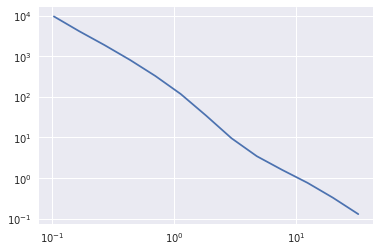

In [18]:
plt.plot(rbc, xi)
plt.loglog();

In [43]:
rbc

array([  0.10378753,   0.16743162,   0.27010324,   0.43573466,
         0.70293378,   1.13398346,   1.82935936,   2.95115035,
         4.76084062,   7.6802605 ,  12.38991304,  19.98759615,  32.2442941 ])

Interpolate with a Gaussian process. May want to do something else "at scale", but this is quick for now. 

In [19]:
import george
from george.kernels import ExpSquaredKernel
kernel = ExpSquaredKernel(0.05)
gp = george.GP(kernel)
gp.compute(np.log10(rpoints))

In [20]:
print xi

[  9.64689465e+03   4.16130871e+03   1.88755923e+03   8.16293120e+02
   3.27757046e+02   1.17700149e+02   3.45436956e+01   9.56597686e+00
   3.44374136e+00   1.58129562e+00   7.57737872e-01   3.25998436e-01
   1.28385455e-01]


In [21]:
xi[xi<=0] = 1e-2 #ack

This plot looks bad on large scales. I will need to implement a linear bias model for larger scales; however I believe this is not the cause of this issue. The overly large correlation function at large scales if anything should increase w(theta). 

This plot shows the regimes of concern. The black lines show the value of r for u=0 in the below integral for each theta bin. The red lines show the maximum value of r for the integral I'm performing.

Perform the below integral in each theta bin:

$$ \Delta \Sigma(\theta) =  \int_0^\infty du \xi_{gm} \left(r = \sqrt{(u \theta)^2 + (u-D_A(z))^2} \right) $$

Where $\bar{x}$ is the median comoving distance to z. 

In [22]:
from scipy.interpolate import interp1d
import pyccl as ccl
from astropy import units

xi_interp = interp1d(np.log10(rbc), np.log10(xi))
'''
names, vals = cat._get_cosmo_param_names_vals()
param_dict = { n:v for n,v in zip(names, vals)}

if 'Omega_c' not in param_dict:
    param_dict['Omega_c'] = param_dict['Omega_m'] - param_dict['Omega_b']
    del param_dict['Omega_m']

cosmo = ccl.Cosmology(**param_dict)

big_rbins = np.logspace(1, 2.1, 21)
big_rbc = (big_rbins[1:] + big_rbins[:-1])/2.0
xi_mm = ccl.correlation_3d(cosmo, cat.a, big_rbc)

#bias2 = np.mean(xi[-3:]/xi_mm[-3:]) #estimate the large scale bias from the box
#note i don't use the bias builtin cuz i've already computed xi_gg. 

xi_mm_interp = interp1d(np.log10(big_rbc), np.log10(xi_mm))

bias2 = np.power(10, xi_interp(1.2)-xi_mm_interp(1.2))
'''

'''
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60 #binning used in buzzard mocks
tpoints = (theta_bins[1:] + theta_bins[:-1])/2.0
ds = np.zeros_like(tpoints)
x = cat.cosmology.angular_diameter_distance(cat.z)/cat.h
print tpoints[0]*x.to("Mpc").value/cat.h, rp_bins[0]
assert tpoints[0]*x.to("Mpc").value/cat.h >= rp_bins[0]
#ubins = np.linspace(10**-6, 10**4.0, 1001)
ubins = np.logspace(-6, 2.0, 501)
ubc = (ubins[1:]+ubins[:-1])/2.0
'''

'\ntheta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60 #binning used in buzzard mocks\ntpoints = (theta_bins[1:] + theta_bins[:-1])/2.0\nds = np.zeros_like(tpoints)\nx = cat.cosmology.angular_diameter_distance(cat.z)/cat.h\nprint tpoints[0]*x.to("Mpc").value/cat.h, rp_bins[0]\nassert tpoints[0]*x.to("Mpc").value/cat.h >= rp_bins[0]\n#ubins = np.linspace(10**-6, 10**4.0, 1001)\nubins = np.logspace(-6, 2.0, 501)\nubc = (ubins[1:]+ubins[:-1])/2.0\n'

In [23]:
rhocrit = cat.cosmology.critical_density(0).to('Msun/(Mpc^3)').value
print rhocrit

1.35992947349e+11


In [24]:
def integrand_medium_scales(lRz, Rp, xi_interp):
    #integrand_params pars=*(integrand_params*)params;
    Rz = np.exp(lRz)
    #print Rz
    out= Rz * 10**xi_interp(np.log10(Rz*Rz + Rp*Rp)*0.5)
    print Rz, out
    return out


In [25]:
from scipy.integrate import quad

In [26]:
np.log10(np.exp(-10))

-4.3429448190325184

In [44]:
def Sigma_at_R_arr(R, Rxi, xi, Om):
    rhom = Om*rhocrit*1e-12 #SM h^2/pc^2/Mpc; integral is over Mpc/h
    Rxi0, Rxi_max = Rxi[0], Rxi[-1]
    
    Sigma = np.zeros_like(R)
    for i, Rp in enumerate(R):
        print Rp
        ln_z_max = np.log(np.sqrt(Rxi_max*Rxi_max - Rp*Rp))#; //Max distance to integrate to
        result2 = quad(integrand_medium_scales, -10, ln_z_max, args=(Rp, xi))[0]
        print result2
        Sigma[i] = result2#(result1+result2)*rhom*2;

    return rhom*2*Sigma

In [45]:
print rpoints

[  0.12365661   0.2613469    0.5523538    1.1673937    2.46727379
   5.21455612  11.0209072   23.29256658]


In [46]:
sigma = Sigma_at_R_arr(rpoints, rbc, xi_interp, cat.cosmology.Om(0))

0.123656612642
0.0382606576343 250.315669123
5.41248590908e-05 0.383739700059
27.0463137864 4.89076749409
0.000112677945028 0.798874625747
12.9916987947 9.05362387072
0.000393555263593 2.79024208134
3.71962481012 21.6769645298
0.00206428053745 14.6319552756
0.709146792818 220.889476889
0.0140343139142 98.3886307636
0.104307052811 461.094050358
4.67477816815e-05 0.331436991979
31.3143826286 4.25615361068
7.26763681824e-05 0.515267927244
20.1424198708 6.46817045734
0.000198754127083 1.40914341443
7.36527056871 12.4652719762
0.000863565789899 6.12233143335
1.69515506489 70.7045631574
0.00526560214457 37.273178118
0.278007696446 425.880235452
0.00131796478301 9.34330367835
4.95708059358e-05 0.351451939783
0.0350414147294 232.130663171
7.15232185382e-05 0.507092220483
0.0242862556351 166.552431029
0.000133668924305 0.94769815074
0.0129950261686 91.2481301627
0.000306134270232 2.17044925106
0.00567408270871 40.154358395
0.000798221063347 5.65909913441
0.00217612795381 15.4243274554
4.6068926

In [29]:
rhom = cat.cosmology.Om(0)*rhocrit*1e-12 #SM h^2/pc^2/Mpc; integral is over Mpc/h
print rhom

0.0388939829419


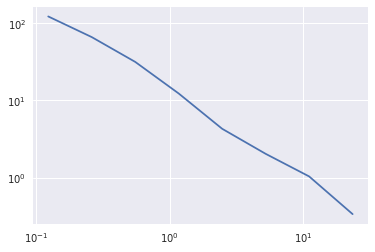

In [30]:
plt.plot(rpoints, sigma)
#plt.xscale('log')
plt.loglog();

In [42]:
print rpoints

[  0.12365661   0.2613469    0.5523538    1.1673937    2.46727379
   5.21455612  11.0209072   23.29256658]


In [31]:
sigma

array([ 121.95145996,   65.90218232,   31.46144416,   12.26835331,
          4.28237926,    2.03088395,    1.03527975,    0.33652141])

In [32]:
def DS_integrand_medium_scales(lR, sigma_interp):
    R = np.exp(lR);
    return R * R * sigma_interp(np.log10(R))


In [33]:
small_scales = r_bins<1.
np.sum(~small_scales)

8

In [50]:
def DeltaSigma_at_R_arr(R, Rs, Sigma):
    lrmin = np.log(Rs[0]);
    DeltaSigma = np.zeros_like(R)
    sigma_interp = interp1d(np.log10(Rs), Sigma)
    print R
    for i,r in enumerate(R):
        result2 = quad(DS_integrand_medium_scales, lrmin, np.log(r), args= (sigma_interp,))[0]
        #print result2*2/(r**2), sigma_interp(np.log10(r));
        #print result2, r, sigma_interp(np.log10(r))
        DeltaSigma[i] = result2*2/(r**2) - sigma_interp(np.log10(r));

    return cat.h*DeltaSigma

In [51]:
rpoints

array([  0.12365661,   0.2613469 ,   0.5523538 ,   1.1673937 ,
         2.46727379,   5.21455612,  11.0209072 ,  23.29256658])

In [52]:
rpoints2 = np.logspace(np.log10(rpoints[0]), np.log10(rpoints[-1]), 500)
ds2 = DeltaSigma_at_R_arr(rpoints, rpoints, sigma)

[  0.12365661   0.2613469    0.5523538    1.1673937    2.46727379
   5.21455612  11.0209072   23.29256658]


In [53]:
print ds2

[-85.36602197   1.23461256  12.77825827   9.82771801   5.0990316
   1.95881561   0.7999249    0.43272762]


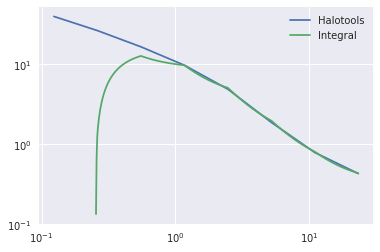

In [33]:
plt.plot(rpoints, ds, label = 'Halotools')
plt.plot(rpoints2, ds2, label = 'Integral')

plt.loglog();
plt.legend(loc = 'best')

In [70]:
ds2

array([-85.80480241, -83.47114606, -81.18597525, -78.94828262,
       -76.75708174, -74.61140665, -72.5103115 , -70.45287005,
       -68.43817533, -66.4653392 , -64.53349199, -62.64178207,
       -60.78937555, -58.97545581, -57.19922324, -55.45989482,
       -53.7567038 , -52.08889938, -50.45574634, -48.85652474,
       -47.2905296 , -45.75707058, -44.25547169, -42.78507098,
       -41.34522027, -39.93528483, -38.55464311, -37.20268649,
       -35.878819  , -34.58245703, -33.3130291 , -32.06997564,
       -30.85274865, -29.66081155, -28.4936389 , -27.35071619,
       -26.23153957, -25.13561569, -24.06246143, -23.01160371,
       -21.98257929, -20.97493455, -19.98822528, -19.02201651,
       -18.07588232, -17.14940563, -16.24217801, -15.35379954,
       -14.48387859, -13.63203168, -12.79788328, -11.9810657 ,
       -11.18121884, -10.39799011,  -9.63103425,  -8.88001316,
        -8.14459576,  -7.42445787,  -6.71928203,  -6.02875738,
        -5.35257951,  -4.69045035,  -4.04207801,  -3.40

In [37]:
# TODO this is like this cause of a half-assed attempt at parraleization
# this is unesscary now, and could be discarded for a simpler for loop
def integrate_xi(bin_no):#, w_theta, bin_no, ubc, ubins)
    int_xi1, int_xi2 = 0, 0 
    #t_med = np.radians(tpoints[bin_no])
    rp = rpoints[bin_no]
    dr = ((rp-rpoints[0])/500)*units.Mpc/cat.h
    for _r in np.linspace(rbc[0]+1e-5, rp, 500):
        if _r < rp:
            continue
        print _r
        r = _r*units.Mpc/cat.h
        for ubin_no, _u in enumerate(ubc):
            _du = ubins[ubin_no+1]-ubins[ubin_no]
            u = _u*units.Mpc/cat.h
            du = _du*units.Mpc/cat.h

            rad = np.sqrt(r**2 + u**2 )#*cat.h#not sure about the h
            
            if rad >= (units.Mpc)*rpoints[-1]:
                try:
                    int_xi1+=du*r*dr*bias2*(np.power(10, \
                            xi_mm_interp(np.log10(rad.value))))
                except ValueError:
                    #interpolation failed
                    int_xi1+=du*0*dr*r
            else:
                int_xi1+=du*r*dr*(np.power(10, \
                            xi_interp(np.log10(rad.value))))
                
    for ubin_no, _u in enumerate(ubc):
        _du = ubins[ubin_no+1]-ubins[ubin_no]
        u = _u*units.Mpc/cat.h
        du = _du*units.Mpc/cat.h

        rad = np.sqrt((rp*units.Mpc)**2 + u**2 )#*cat.h#not sure about the h

        if rad >= (units.Mpc)*rpoints[-1]:
            try:
                int_xi2+=du*bias2*(np.power(10, \
                        xi_mm_interp(np.log10(rad.value))))
            except ValueError:
                #interpolation failed
                int_xi2+=du*0
        else:
            int_xi2+=du*(np.power(10, \
                        xi_interp(np.log10(rad.value))))
            
    print int_xi1, int_xi2
    ds[bin_no] = ( (4/( (rp*units.Mpc)**2))*int_xi1 - 2*int_xi2).value

#Currently this doesn't work cuz you can't pickle the integrate_xi function.
#I'll just ignore for now. This is why i'm making an emulator anyway
#p = Pool(n_cores)  
map(integrate_xi, range(rpoints.shape[0]))
#p.map(integrate_xi, range(tpoints.shape[0]))
#p.terminate()

print ds

0.123656612642


NameError: global name 'ubc' is not defined

The below plot shows the problem. There appears to be a constant multiplicative offset between the redmagic calculation and the one we just performed. The plot below it shows their ratio. It is near-constant, but there is some small radial trend. Whether or not it is significant is tough to say. 

In [ ]:
plt.plot(tpoints, ds, label = 'My Calculation')
plt.plot(tpoints_rm, ds, label = 'Halotools')
#plt.plot(tpoints_rm, W.to("1/Mpc").value*mathematica_calc, label = 'Mathematica Calc')
#plt.plot(tpoints, wt_analytic(m,10**b, np.radians(tpoints), x),label = 'Mathematica Calc' )

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [38]:
wt_redmagic/(W.to("1/Mpc").value*mathematica_calc)

NameError: name 'wt_redmagic' is not defined

In [ ]:
import cPickle as pickle
with open('/u/ki/jderose/ki23/bigbrother-addgals/bbout/buzzard-flock/buzzard-0/buzzard0_lb1050_xigg_ministry.pkl') as f:
    xi_rm = pickle.load(f)

In [ ]:
xi_rm.metrics[0].xi.shape

In [ ]:
xi_rm.metrics[0].mbins

In [ ]:
xi_rm.metrics[0].cbins

In [ ]:
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(rpoints, xi)
for i in xrange(3):
    for j in xrange(3):
        plt.plot(xi_rm.metrics[0].rbins[:-1], xi_rm.metrics[0].xi[:,i,j,0])
plt.loglog();

In [ ]:
plt.subplot(211)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
#plt.ylim([0,10])
plt.subplot(212)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
plt.ylim([2.0,4])

In [ ]:
xi_rm.metrics[0].xi.shape

In [ ]:
xi_rm.metrics[0].rbins #Mpc/h

The below cell calculates the integrals jointly instead of separately. It doesn't change the results significantly, but is quite slow. I've disabled it for that reason. 

In [ ]:
x = cat.cosmology.comoving_distance(z)*a
#ubins = np.linspace(10**-6, 10**2.0, 1001)
ubins = np.logspace(-6, 2.0, 51)
ubc = (ubins[1:]+ubins[:-1])/2.0

#NLL
def liklihood(params, wt_redmagic,x, tpoints):
    #print _params
    #prior  = np.array([ PRIORS[pname][0] < v < PRIORS[pname][1] for v,pname in zip(_params, param_names)])
    #print param_names
    #print prior
    #if not np.all(prior):
    #    return 1e9
    #params = {p:v for p,v in zip(param_names, _params)}
    #cat.populate(params)
    #nd_cat =  cat.calc_analytic_nd(parmas)
    #wt = np.zeros_like(tpoints_rm[:-5])
    
    #xi = cat.calc_xi(r_bins, do_jackknife=False)
    #m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))
    
    #if np.any(xi < 0):
    #    return 1e9
    #kernel = ExpSquaredKernel(0.05)
    #gp = george.GP(kernel)
    #gp.compute(np.log10(rpoints))
    
    #for bin_no, t_med in enumerate(np.radians(tpoints_rm[:-5])):
    #    int_xi = 0
    #    for ubin_no, _u in enumerate(ubc):
    #        _du = ubins[ubin_no+1]-ubins[ubin_no]
    #        u = _u*unit.Mpc*a
    #        du = _du*unit.Mpc*a
            #print np.sqrt(u**2+(x*t_med)**2)
    #        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h
            #if r > unit.Mpc*10**1.7: #ignore large scales. In the full implementation this will be a transition to a bias model. 
            #    int_xi+=du*0
            #else:
                # the GP predicts in log, so i predict in log and re-exponate
            #    int_xi+=du*(np.power(10, \
            #            gp.predict(np.log10(xi), np.log10(r.value), mean_only=True)[0]))
    #        int_xi+=du*(10**b)*(r.to("Mpc").value**m)

        #print (((int_xi*W))/wt_redmagic[0]).to("m/m")
        #break
    #    wt[bin_no] = int_xi*W.to("1/Mpc")
        
    wt = wt_analytic(params[0],params[1], tpoints, x.to("Mpc").value)   
    chi2 = np.sum(((wt - wt_redmagic[:-5])**2)/(1e-3*wt_redmagic[:-5]) )
    
    #chi2=0
    #print nd_cat
    #print wt
    #chi2+= ((nd_cat-nd_mock.value)**2)/(1e-6)
    
    #mf = cat.calc_mf()
    #HOD = cat.calc_hod()
    #mass_bin_range = (9,16)
    #mass_bin_size = 0.01
    #mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

    #mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
    #                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
        
    #chi2+=((13.35-np.log10(mean_host_mass))**2)/(0.2)
    print chi2
    return chi2 #nll

In [ ]:
print nd_mock
print wt_redmagic[:-5]

In [ ]:
import scipy.optimize as op

In [ ]:
results = op.minimize(liklihood, np.array([-2.2, 10**1.7]),(wt_redmagic,x, tpoints_rm[:-5]))

In [ ]:
results

In [ ]:
#plt.plot(tpoints_rm, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
plt.plot(tpoints_rm, wt_analytic(-1.88359, 2.22353827e+03,tpoints_rm, x.to("Mpc").value), label = 'Mathematica Calc')

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [ ]:
plt.plot(np.log10(rpoints), np.log10(2.22353827e+03)+(np.log10(rpoints)*(-1.88)))
plt.scatter(np.log10(rpoints), np.log10(xi) )


In [ ]:
np.array([v for v in params.values()])